In [0]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import torchvision
import time
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [0]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
])
dataset = torchvision.datasets.FashionMNIST('./data/', download=True, transform=transform, train=True)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            #Input layer
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            #Second layer
            nn.Linear(1024, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            #Third layer
            nn.Linear(512, 256),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            #Final layer - output layer
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        #print(c)
        x = torch.cat((c, x), -1)
        out = self.model(x)
        return out.squeeze()

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_embeddings = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            #First layer - Input layer
            nn.Linear(110, 256),
            nn.BatchNorm1d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            #Second layer
            nn.Linear(256, 512),
            nn.BatchNorm1d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            #Third layer
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            #Last layer
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_embeddings(labels)
        #print(c)
        x = torch.cat((c.float(), z.float()), -1)
        out = self.model(x)
        #img = img.view(img.size(0), *img_shape)  
        return out.view(x.size(0), 28, 28)

In [0]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

In [0]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [0]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.LongTensor(np.random.normal(0, 1, (batch_size, 100)))).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
    g_loss.backward()
    #Use for loop to replace step()
    #Or come up with a function to avoid discriminator being trained as well
    g_optimizer.step()
    return g_loss.item()

In [0]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size) - 0.1).cuda())
    
    # train with fake images
    z = Variable(torch.LongTensor(np.random.normal(0, 1, (batch_size, 100)))).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size) + 0.2).cuda())
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.item()

In [0]:
def getsampleimage(G, n_noise=100):
    """
        save sample 100 images
    """

    z = Variable(torch.LongTensor(np.random.normal(0, 1, (10, 100)))).cuda()
    labels = Variable(torch.LongTensor(np.arange(10))).cuda()
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    img = np.zeros([280, 280])
    for j in range(10):
        c = torch.zeros([10, 10]).cuda()
        c[:, j] = 1
        z = torch.randn(10, n_noise).cuda()
        y_hat = G(z,c).view(10, 28, 28)
        result = y_hat.cpu().data.numpy()
        img[j*28:(j+1)*28] = np.concatenate([x for x in result], axis=-1)
    return img

Starting epoch 0...
g_loss: 1.1826446056365967, d_loss: 1.0814534425735474


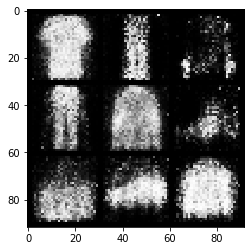

Starting epoch 1...
g_loss: 0.6733022332191467, d_loss: 1.268837809562683


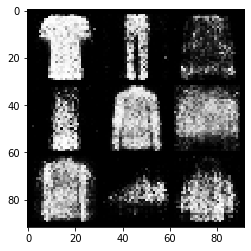

Starting epoch 2...
g_loss: 0.680320680141449, d_loss: 1.1690220832824707


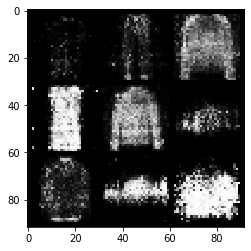

Starting epoch 3...
g_loss: 0.8874421119689941, d_loss: 1.273322343826294


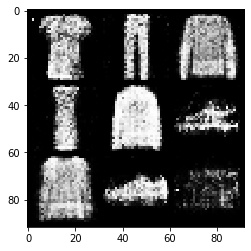

Starting epoch 4...
g_loss: 0.9768776893615723, d_loss: 1.2282878160476685


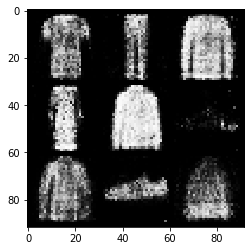

Starting epoch 5...
g_loss: 0.9354933500289917, d_loss: 1.1892940998077393


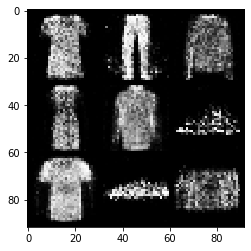

Starting epoch 6...
g_loss: 0.7830944061279297, d_loss: 1.1900737285614014


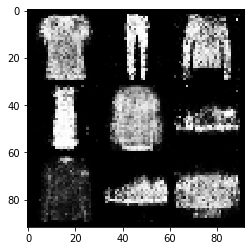

Starting epoch 7...
g_loss: 0.6531684398651123, d_loss: 1.2750476598739624


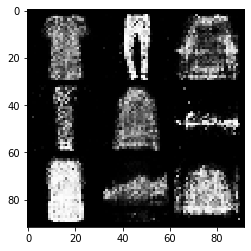

Starting epoch 8...
g_loss: 0.8710575699806213, d_loss: 1.3745739459991455


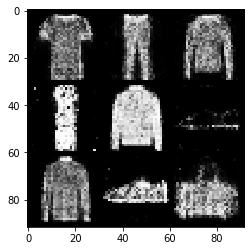

Starting epoch 9...
g_loss: 0.6761199235916138, d_loss: 1.2770581245422363


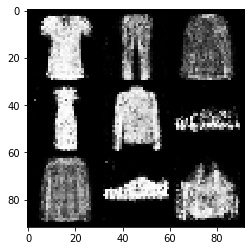

Starting epoch 10...
g_loss: 0.6479511260986328, d_loss: 1.3175995349884033


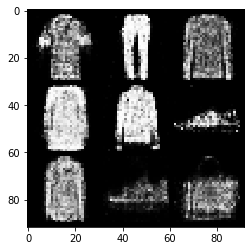

Starting epoch 11...
g_loss: 0.5751491785049438, d_loss: 1.281580924987793


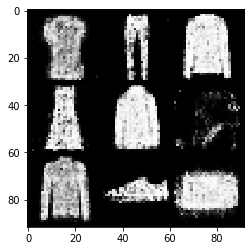

Starting epoch 12...
g_loss: 0.7414999008178711, d_loss: 1.32265305519104


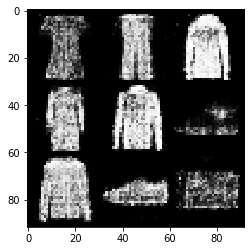

Starting epoch 13...
g_loss: 0.6060588359832764, d_loss: 1.239443063735962


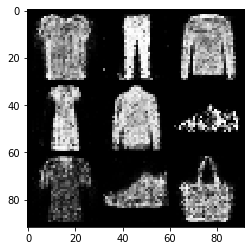

Starting epoch 14...
g_loss: 0.6863938570022583, d_loss: 1.346993088722229


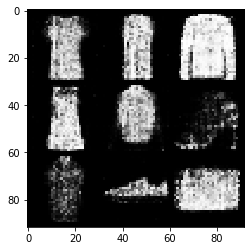

Starting epoch 15...
g_loss: 0.6718757748603821, d_loss: 1.3470187187194824


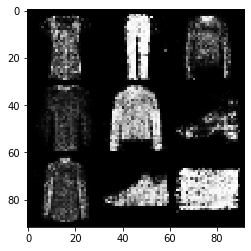

Starting epoch 16...
g_loss: 0.6311957836151123, d_loss: 1.3360669612884521


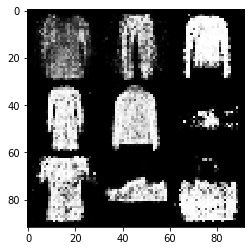

Starting epoch 17...
g_loss: 0.6778331995010376, d_loss: 1.2978205680847168


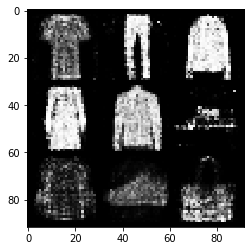

Starting epoch 18...
g_loss: 0.6182491779327393, d_loss: 1.255987524986267


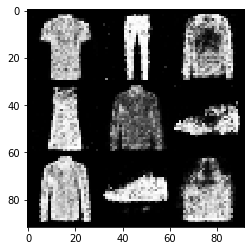

Starting epoch 19...
g_loss: 0.7364057302474976, d_loss: 1.430776834487915


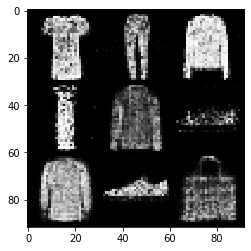

Starting epoch 20...
g_loss: 0.6316207647323608, d_loss: 1.3483877182006836


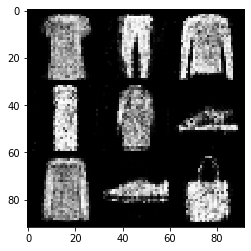

Starting epoch 21...
g_loss: 0.541271448135376, d_loss: 1.306654930114746


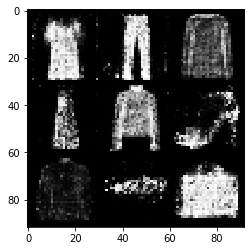

Starting epoch 22...
g_loss: 0.6679964065551758, d_loss: 1.3568153381347656


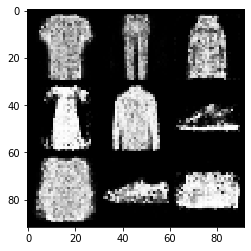

Starting epoch 23...
g_loss: 0.6110771894454956, d_loss: 1.410987377166748


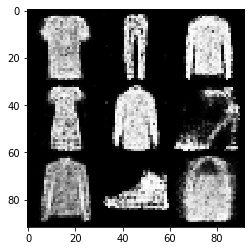

Starting epoch 24...
g_loss: 0.6269633173942566, d_loss: 1.3341076374053955


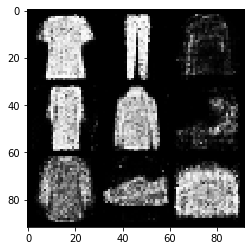

Starting epoch 25...
g_loss: 0.6701909899711609, d_loss: 1.3570520877838135


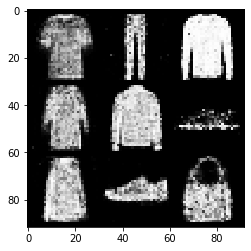

Starting epoch 26...
g_loss: 0.7150102257728577, d_loss: 1.37326979637146


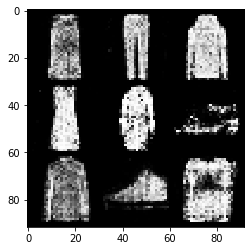

Starting epoch 27...
g_loss: 0.721192479133606, d_loss: 1.3718159198760986


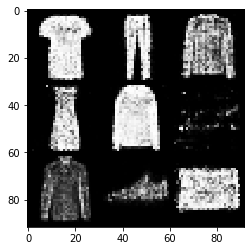

Starting epoch 28...
g_loss: 0.6362380981445312, d_loss: 1.314612627029419


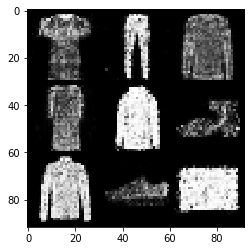

Starting epoch 29...
g_loss: 0.6538267731666565, d_loss: 1.2878376245498657


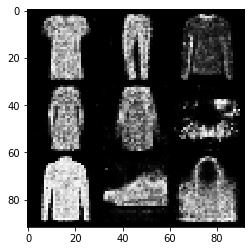

Starting epoch 30...
g_loss: 0.6607891321182251, d_loss: 1.3320903778076172


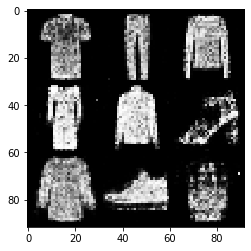

Starting epoch 31...
g_loss: 0.7169010639190674, d_loss: 1.3744208812713623


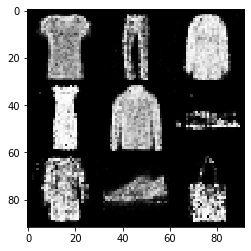

Starting epoch 32...
g_loss: 0.6120625734329224, d_loss: 1.3721946477890015


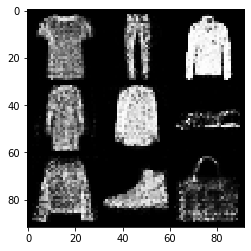

Starting epoch 33...
g_loss: 0.770198404788971, d_loss: 1.3633193969726562


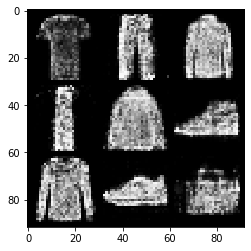

Starting epoch 34...
g_loss: 0.6346076130867004, d_loss: 1.287750244140625


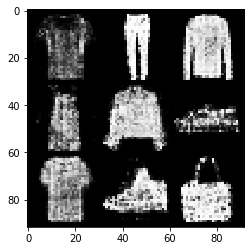

Starting epoch 35...
g_loss: 0.6960384845733643, d_loss: 1.3343210220336914


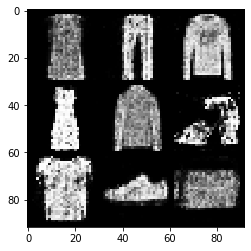

Starting epoch 36...
g_loss: 0.6304125785827637, d_loss: 1.3242697715759277


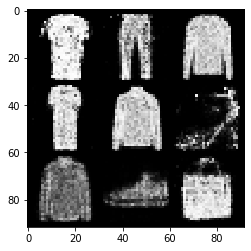

Starting epoch 37...
g_loss: 0.679827094078064, d_loss: 1.3020973205566406


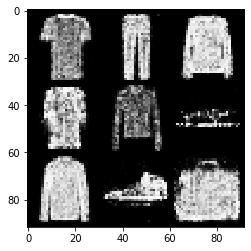

Starting epoch 38...
g_loss: 0.6197928190231323, d_loss: 1.3229185342788696


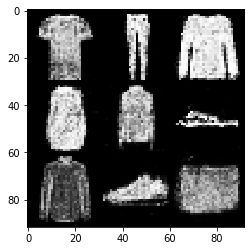

Starting epoch 39...
g_loss: 0.6221786141395569, d_loss: 1.376481056213379


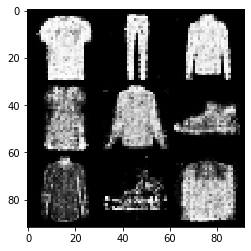

Starting epoch 40...
g_loss: 0.7269958257675171, d_loss: 1.4021427631378174


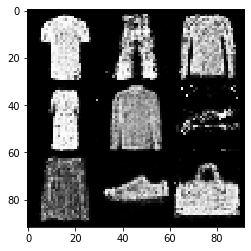

Starting epoch 41...
g_loss: 0.6896979212760925, d_loss: 1.347177267074585


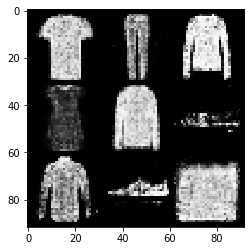

Starting epoch 42...
g_loss: 0.6344358921051025, d_loss: 1.3482604026794434


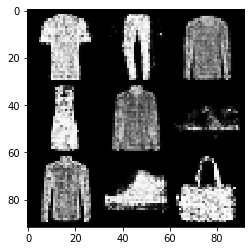

Starting epoch 43...
g_loss: 0.655519962310791, d_loss: 1.3200275897979736


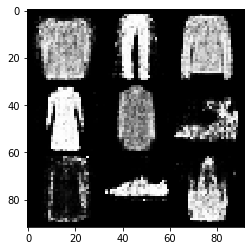

Starting epoch 44...
g_loss: 0.721583366394043, d_loss: 1.3627691268920898


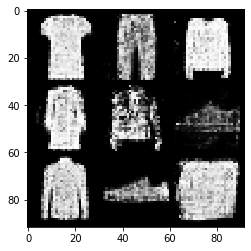

Starting epoch 45...
g_loss: 0.6545248031616211, d_loss: 1.3349846601486206


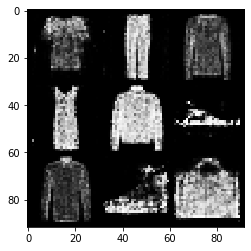

Starting epoch 46...
g_loss: 0.6228107810020447, d_loss: 1.3298357725143433


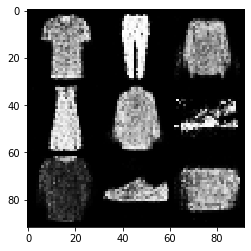

Starting epoch 47...
g_loss: 0.644255518913269, d_loss: 1.2693815231323242


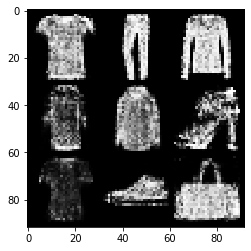

Starting epoch 48...
g_loss: 0.6921567320823669, d_loss: 1.314624309539795


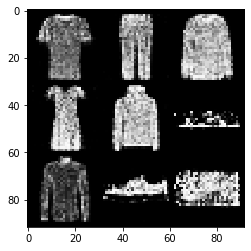

Starting epoch 49...
g_loss: 0.6281592845916748, d_loss: 1.3686258792877197


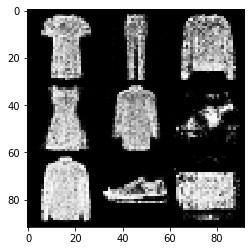

Starting epoch 50...
g_loss: 0.6361769437789917, d_loss: 1.3074235916137695


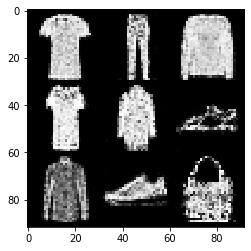

Starting epoch 51...
g_loss: 0.6006826162338257, d_loss: 1.3735768795013428


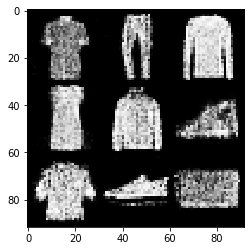

Starting epoch 52...
g_loss: 0.589939296245575, d_loss: 1.3433573246002197


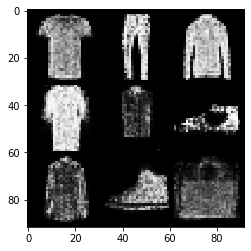

Starting epoch 53...
g_loss: 0.6404023766517639, d_loss: 1.291325330734253


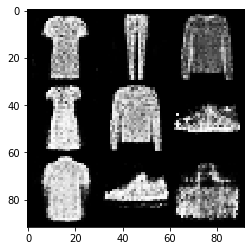

Starting epoch 54...
g_loss: 0.7038304805755615, d_loss: 1.381291151046753


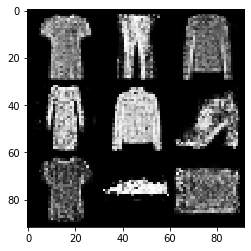

Starting epoch 55...
g_loss: 0.6769351959228516, d_loss: 1.2994279861450195


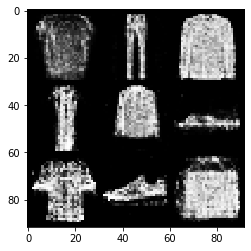

Starting epoch 56...
g_loss: 0.7549225091934204, d_loss: 1.3505558967590332


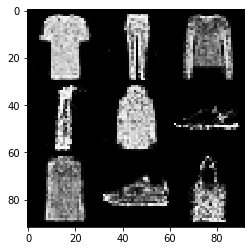

Starting epoch 57...
g_loss: 0.7654572129249573, d_loss: 1.3929953575134277


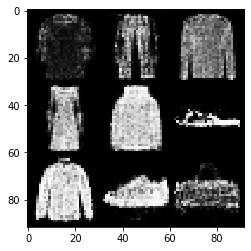

Starting epoch 58...
g_loss: 0.6314254403114319, d_loss: 1.284358263015747


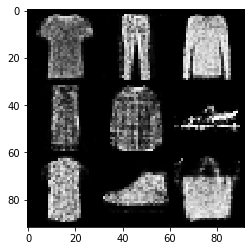

Starting epoch 59...
g_loss: 0.7248425483703613, d_loss: 1.3162587881088257


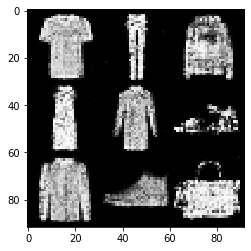

Starting epoch 60...
g_loss: 0.5594298839569092, d_loss: 1.3563140630722046


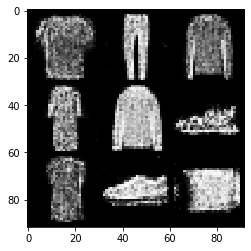

Starting epoch 61...
g_loss: 0.662589430809021, d_loss: 1.3286329507827759


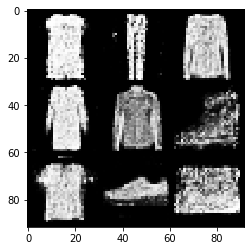

Starting epoch 62...
g_loss: 0.6043537855148315, d_loss: 1.260679006576538


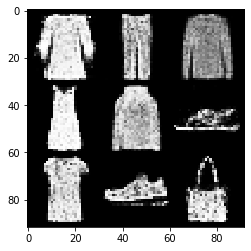

Starting epoch 63...
g_loss: 0.5848631858825684, d_loss: 1.2896208763122559


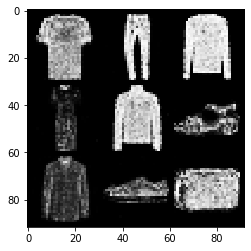

Starting epoch 64...
g_loss: 0.6856978535652161, d_loss: 1.2989132404327393


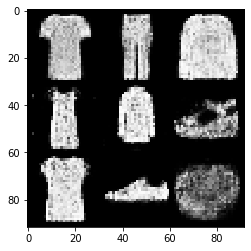

Starting epoch 65...
g_loss: 0.6872926950454712, d_loss: 1.3011459112167358


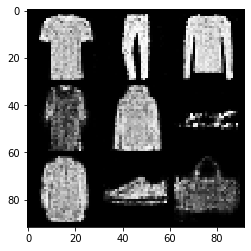

Starting epoch 66...
g_loss: 0.7045549154281616, d_loss: 1.2688919305801392


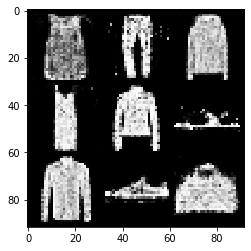

Starting epoch 67...
g_loss: 0.6129477620124817, d_loss: 1.3048772811889648


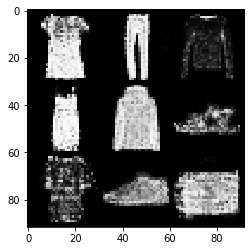

Starting epoch 68...
g_loss: 0.7000781297683716, d_loss: 1.2917871475219727


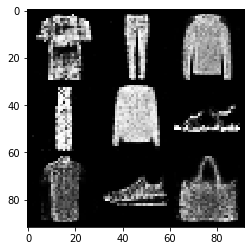

Starting epoch 69...
g_loss: 0.7883902192115784, d_loss: 1.3108272552490234


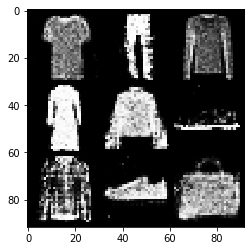

Starting epoch 70...
g_loss: 0.624616265296936, d_loss: 1.365251064300537


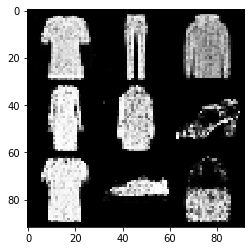

Starting epoch 71...
g_loss: 0.6905403137207031, d_loss: 1.3446483612060547


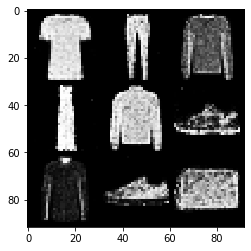

Starting epoch 72...
g_loss: 0.6174213886260986, d_loss: 1.2638027667999268


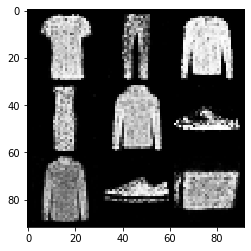

Starting epoch 73...
g_loss: 0.6820050477981567, d_loss: 1.3215463161468506


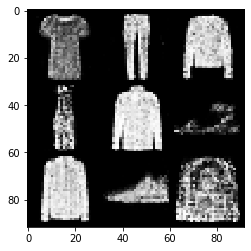

Starting epoch 74...
g_loss: 0.658100962638855, d_loss: 1.267150640487671


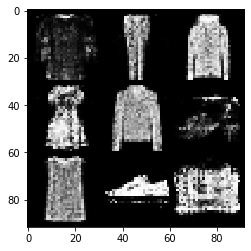

Starting epoch 75...
g_loss: 0.7191650867462158, d_loss: 1.328498125076294


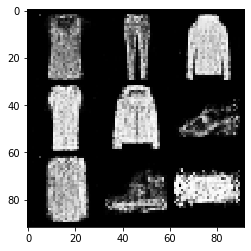

Starting epoch 76...
g_loss: 0.7158712148666382, d_loss: 1.3648571968078613


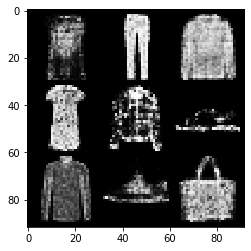

Starting epoch 77...
g_loss: 0.6384625434875488, d_loss: 1.3162533044815063


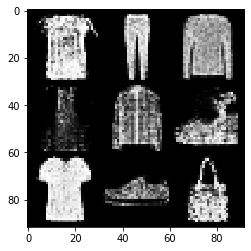

Starting epoch 78...
g_loss: 0.7485702037811279, d_loss: 1.2990007400512695


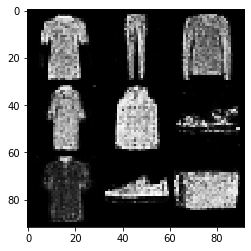

Starting epoch 79...
g_loss: 0.8511983752250671, d_loss: 1.3264026641845703


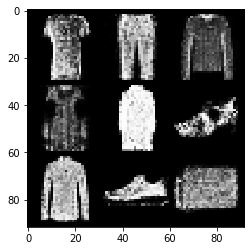

Starting epoch 80...
g_loss: 0.7264602184295654, d_loss: 1.3114163875579834


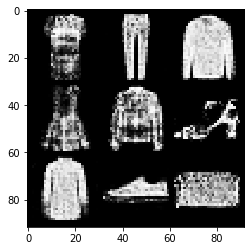

Starting epoch 81...
g_loss: 0.7073789238929749, d_loss: 1.2724515199661255


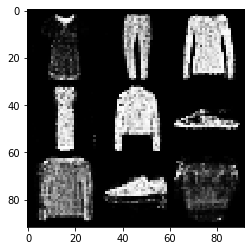

Starting epoch 82...
g_loss: 0.6836827993392944, d_loss: 1.3259849548339844


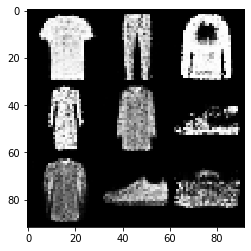

Starting epoch 83...
g_loss: 0.7987672090530396, d_loss: 1.3179495334625244


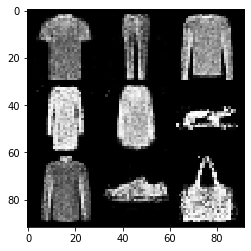

Starting epoch 84...
g_loss: 0.5981842875480652, d_loss: 1.2889561653137207


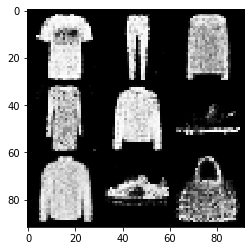

Starting epoch 85...
g_loss: 0.6402122378349304, d_loss: 1.3383859395980835


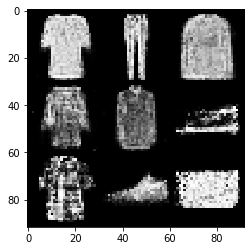

Starting epoch 86...
g_loss: 0.627576470375061, d_loss: 1.3109264373779297


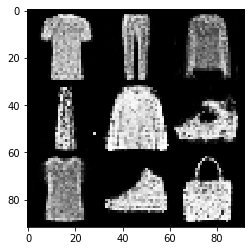

Starting epoch 87...
g_loss: 0.7201975584030151, d_loss: 1.356032133102417


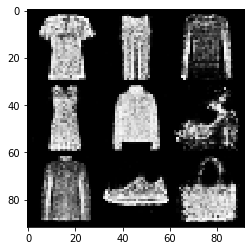

Starting epoch 88...
g_loss: 0.7184447050094604, d_loss: 1.3153373003005981


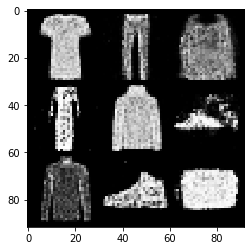

Starting epoch 89...
g_loss: 0.6163169145584106, d_loss: 1.3092800378799438


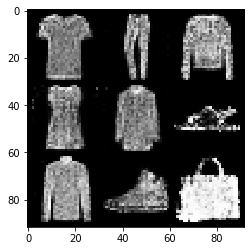

Starting epoch 90...
g_loss: 0.6908289194107056, d_loss: 1.3091334104537964


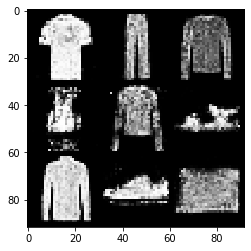

Starting epoch 91...
g_loss: 0.7328510284423828, d_loss: 1.303216814994812


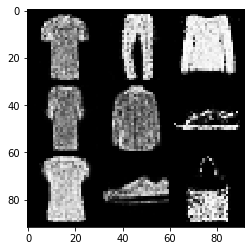

Starting epoch 92...
g_loss: 0.6577168703079224, d_loss: 1.3238648176193237


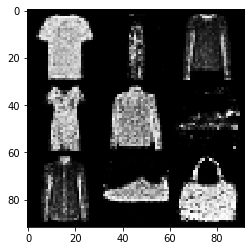

Starting epoch 93...
g_loss: 0.6155519485473633, d_loss: 1.3762749433517456


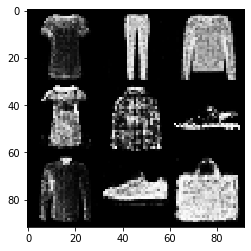

Starting epoch 94...
g_loss: 0.6479611396789551, d_loss: 1.2889366149902344


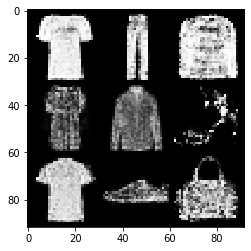

Starting epoch 95...
g_loss: 0.6736900210380554, d_loss: 1.353165864944458


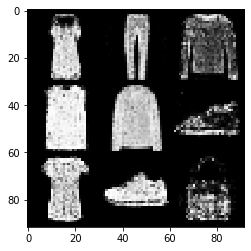

Starting epoch 96...
g_loss: 0.7347878813743591, d_loss: 1.2989037036895752


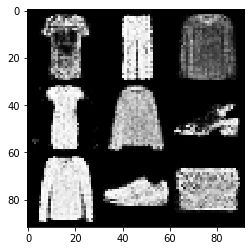

Starting epoch 97...
g_loss: 0.7768609523773193, d_loss: 1.3485887050628662


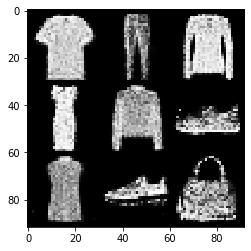

Starting epoch 98...
g_loss: 0.7071576118469238, d_loss: 1.3375266790390015


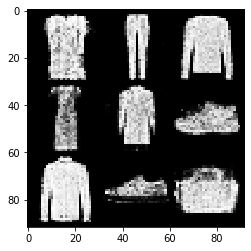

Starting epoch 99...
g_loss: 0.669113278388977, d_loss: 1.3471521139144897


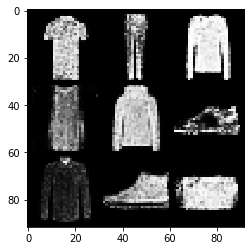

Starting epoch 100...
g_loss: 0.6794174313545227, d_loss: 1.3012497425079346


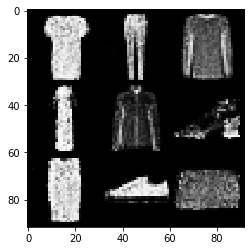

Starting epoch 101...
g_loss: 0.6841681003570557, d_loss: 1.3484644889831543


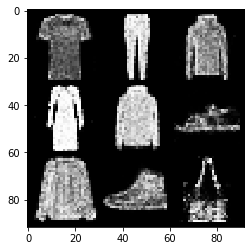

Starting epoch 102...
g_loss: 0.6145851612091064, d_loss: 1.3335953950881958


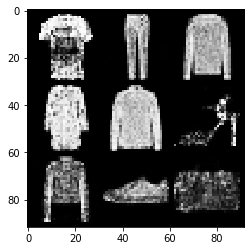

Starting epoch 103...
g_loss: 0.6435743570327759, d_loss: 1.3008320331573486


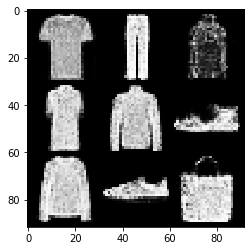

Starting epoch 104...
g_loss: 0.7706830501556396, d_loss: 1.2976067066192627


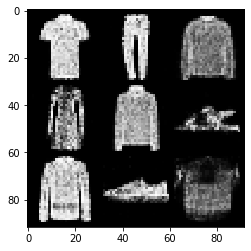

Starting epoch 105...
g_loss: 0.6720703840255737, d_loss: 1.331113576889038


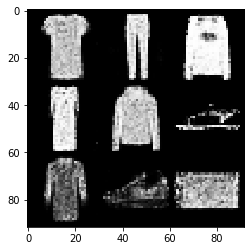

Starting epoch 106...
g_loss: 0.7068741321563721, d_loss: 1.2644456624984741


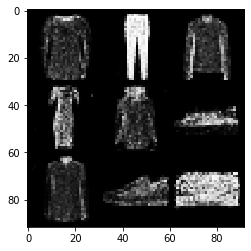

Starting epoch 107...
g_loss: 0.6959194540977478, d_loss: 1.2685632705688477


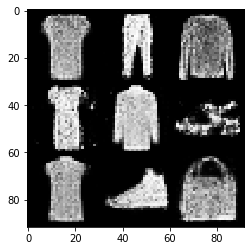

Starting epoch 108...
g_loss: 0.8623870611190796, d_loss: 1.34494948387146


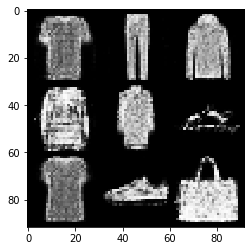

Starting epoch 109...
g_loss: 0.7899579405784607, d_loss: 1.314017653465271


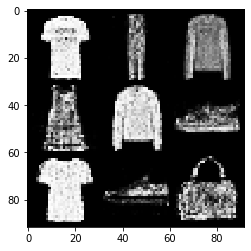

Starting epoch 110...
g_loss: 0.6548663973808289, d_loss: 1.3064861297607422


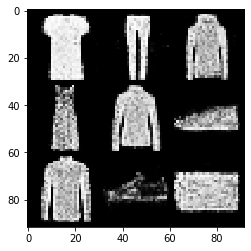

Starting epoch 111...
g_loss: 0.6880674958229065, d_loss: 1.2911467552185059


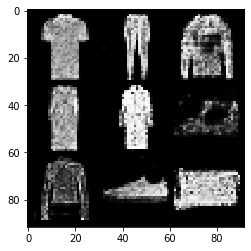

Starting epoch 112...
g_loss: 0.7120370864868164, d_loss: 1.377897024154663


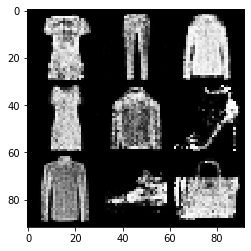

Starting epoch 113...
g_loss: 0.725117027759552, d_loss: 1.2957849502563477


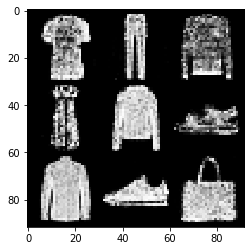

Starting epoch 114...
g_loss: 0.7573380470275879, d_loss: 1.2688193321228027


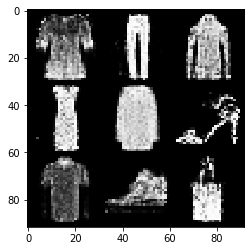

Starting epoch 115...
g_loss: 0.6092395782470703, d_loss: 1.255103349685669


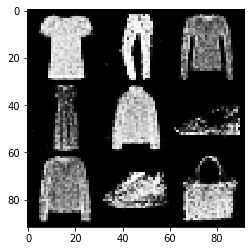

Starting epoch 116...
g_loss: 0.6109114289283752, d_loss: 1.354496955871582


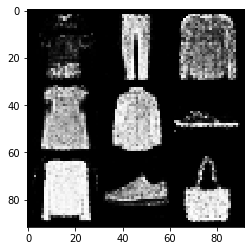

Starting epoch 117...
g_loss: 0.6143197417259216, d_loss: 1.311867356300354


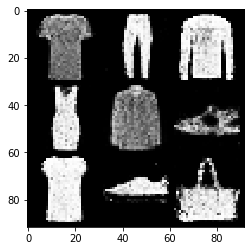

Starting epoch 118...
g_loss: 0.7278839349746704, d_loss: 1.3034619092941284


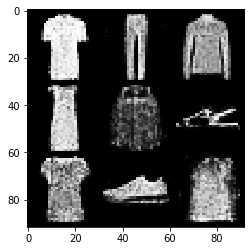

Starting epoch 119...
g_loss: 0.6812953948974609, d_loss: 1.311309814453125


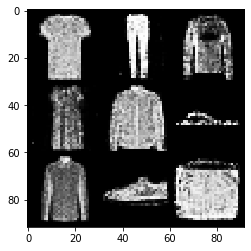

Starting epoch 120...
g_loss: 0.8207361698150635, d_loss: 1.3171863555908203


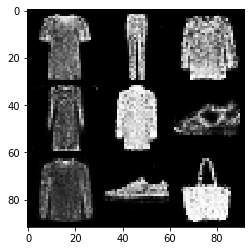

Starting epoch 121...
g_loss: 0.7695895433425903, d_loss: 1.2801138162612915


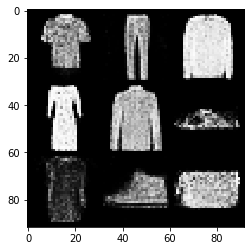

Starting epoch 122...
g_loss: 0.6917709112167358, d_loss: 1.2800514698028564


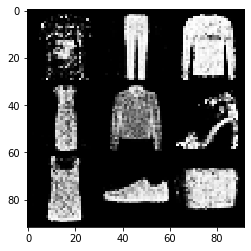

Starting epoch 123...
g_loss: 0.7485044002532959, d_loss: 1.283022403717041


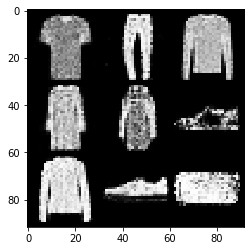

Starting epoch 124...
g_loss: 0.7861923575401306, d_loss: 1.2667186260223389


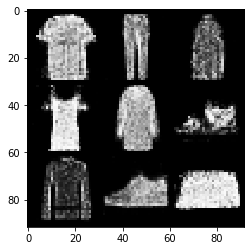

Starting epoch 125...
g_loss: 0.7630490660667419, d_loss: 1.3551888465881348


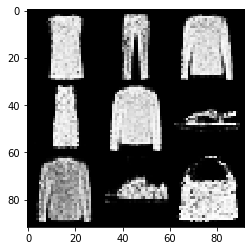

Starting epoch 126...
g_loss: 0.7367198467254639, d_loss: 1.3091826438903809


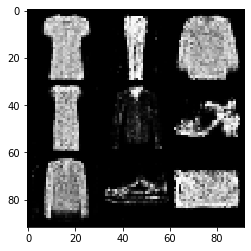

Starting epoch 127...
g_loss: 0.6951756477355957, d_loss: 1.2798542976379395


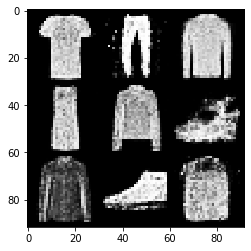

Starting epoch 128...
g_loss: 0.710099458694458, d_loss: 1.2807753086090088


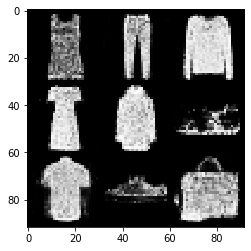

Starting epoch 129...
g_loss: 0.7357801198959351, d_loss: 1.3640176057815552


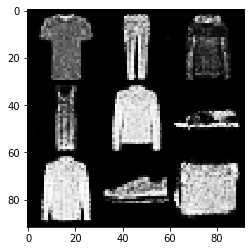

Starting epoch 130...
g_loss: 0.6709161996841431, d_loss: 1.2739406824111938


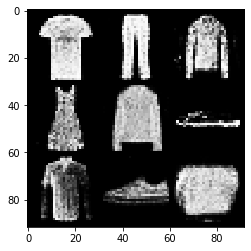

Starting epoch 131...
g_loss: 0.7107305526733398, d_loss: 1.2850453853607178


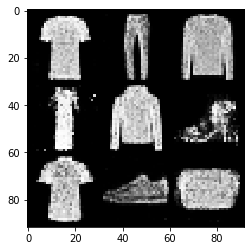

Starting epoch 132...
g_loss: 0.7261832356452942, d_loss: 1.3144296407699585


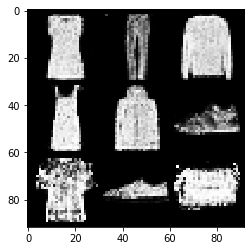

Starting epoch 133...
g_loss: 0.7515417337417603, d_loss: 1.309786319732666


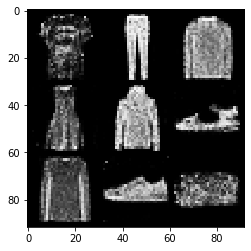

Starting epoch 134...
g_loss: 0.7355687618255615, d_loss: 1.3005908727645874


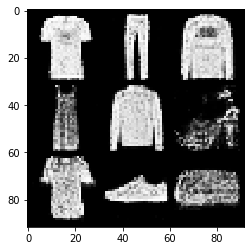

Starting epoch 135...
g_loss: 0.7026700973510742, d_loss: 1.345726728439331


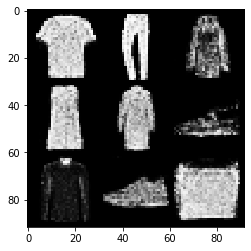

Starting epoch 136...
g_loss: 0.8039234280586243, d_loss: 1.2830262184143066


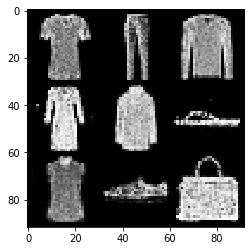

Starting epoch 137...
g_loss: 0.8023424744606018, d_loss: 1.342131495475769


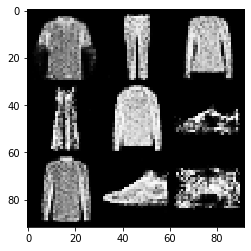

Starting epoch 138...
g_loss: 0.7522304058074951, d_loss: 1.2566343545913696


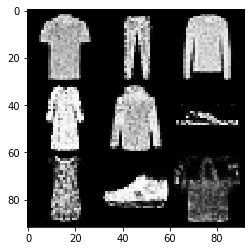

Starting epoch 139...
g_loss: 0.7698231935501099, d_loss: 1.348055362701416


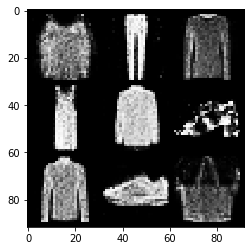

Starting epoch 140...
g_loss: 0.8457844257354736, d_loss: 1.4052650928497314


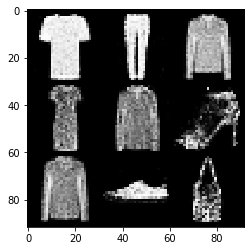

Starting epoch 141...
g_loss: 0.8470566272735596, d_loss: 1.244917392730713


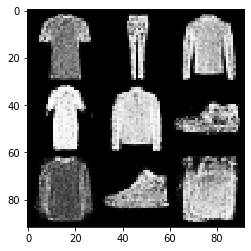

Starting epoch 142...
g_loss: 0.7560690641403198, d_loss: 1.2967462539672852


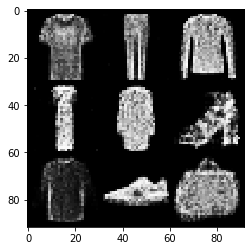

Starting epoch 143...
g_loss: 0.6656943559646606, d_loss: 1.2345929145812988


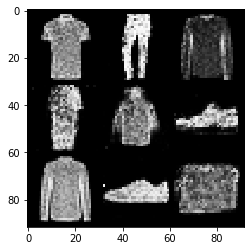

Starting epoch 144...
g_loss: 0.7315877676010132, d_loss: 1.2928540706634521


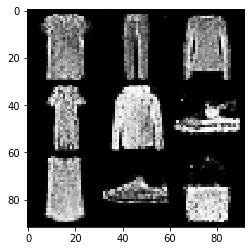

Starting epoch 145...
g_loss: 0.8082609176635742, d_loss: 1.2337077856063843


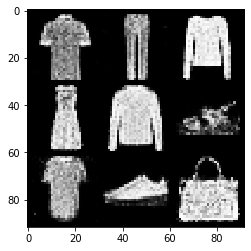

Starting epoch 146...
g_loss: 0.6369342803955078, d_loss: 1.2563931941986084


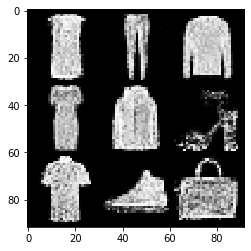

Starting epoch 147...
g_loss: 0.6350269317626953, d_loss: 1.3590651750564575


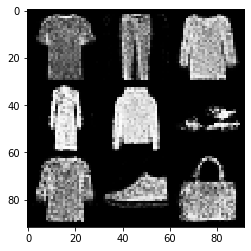

Starting epoch 148...
g_loss: 0.793977677822113, d_loss: 1.248026728630066


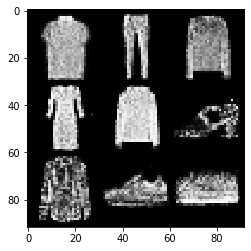

Starting epoch 149...
g_loss: 0.7846832871437073, d_loss: 1.3449429273605347


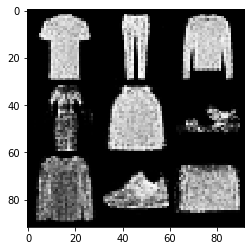

Starting epoch 150...
g_loss: 0.8405762910842896, d_loss: 1.2807188034057617


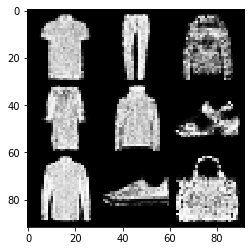

Starting epoch 151...
g_loss: 0.720102071762085, d_loss: 1.2488807439804077


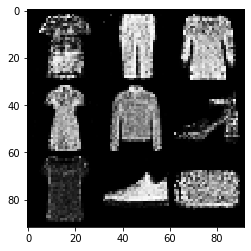

Starting epoch 152...
g_loss: 0.8036742210388184, d_loss: 1.3743336200714111


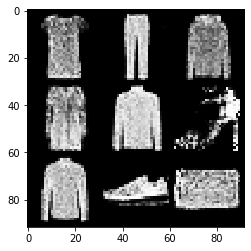

Starting epoch 153...
g_loss: 0.6762527227401733, d_loss: 1.341636061668396


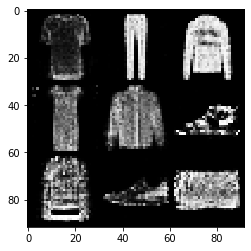

Starting epoch 154...
g_loss: 0.6970429420471191, d_loss: 1.2880282402038574


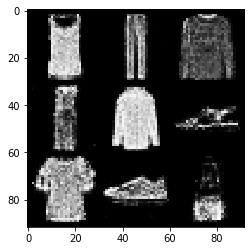

Starting epoch 155...
g_loss: 0.6517231464385986, d_loss: 1.3073219060897827


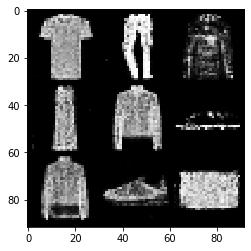

Starting epoch 156...
g_loss: 0.7564867734909058, d_loss: 1.2891244888305664


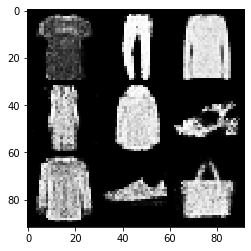

Starting epoch 157...
g_loss: 0.7996504306793213, d_loss: 1.334184169769287


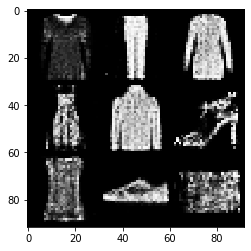

Starting epoch 158...
g_loss: 0.778326153755188, d_loss: 1.3468701839447021


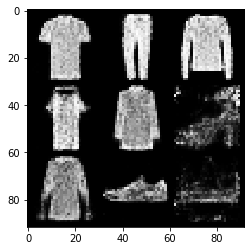

Starting epoch 159...
g_loss: 0.800175130367279, d_loss: 1.2733234167099


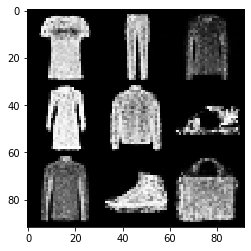

Starting epoch 160...
g_loss: 0.7298053503036499, d_loss: 1.2555235624313354


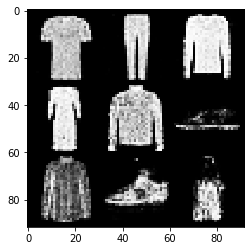

Starting epoch 161...
g_loss: 0.7616441249847412, d_loss: 1.3695008754730225


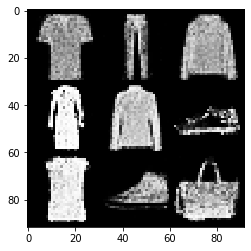

Starting epoch 162...
g_loss: 0.73818439245224, d_loss: 1.246509313583374


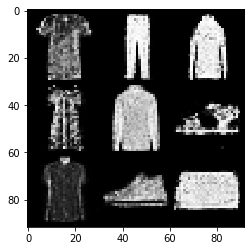

Starting epoch 163...
g_loss: 0.6796832084655762, d_loss: 1.2445523738861084


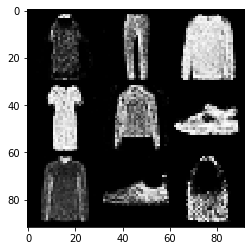

Starting epoch 164...
g_loss: 0.8575073480606079, d_loss: 1.3055473566055298


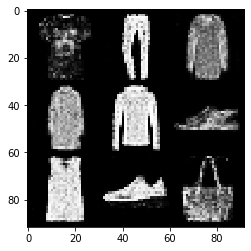

Starting epoch 165...
g_loss: 0.7199341058731079, d_loss: 1.2142739295959473


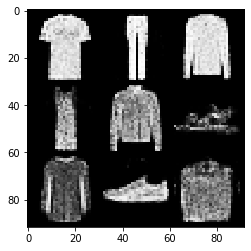

Starting epoch 166...
g_loss: 0.5887770652770996, d_loss: 1.291689395904541


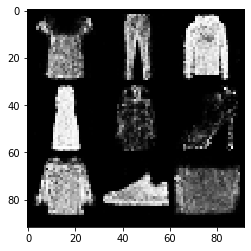

Starting epoch 167...
g_loss: 0.7727850079536438, d_loss: 1.2924566268920898


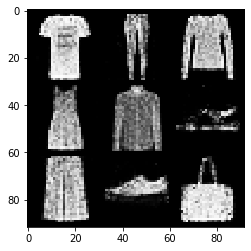

Starting epoch 168...
g_loss: 0.7959638833999634, d_loss: 1.3127009868621826


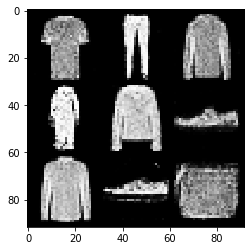

Starting epoch 169...
g_loss: 0.7650384902954102, d_loss: 1.2245376110076904


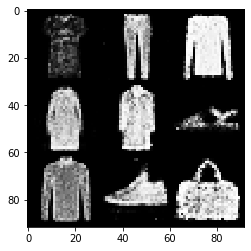

Starting epoch 170...
g_loss: 0.7747405767440796, d_loss: 1.2431809902191162


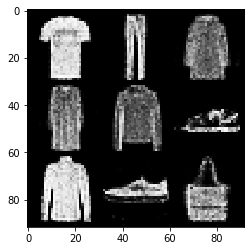

Starting epoch 171...
g_loss: 0.8816831707954407, d_loss: 1.266103982925415


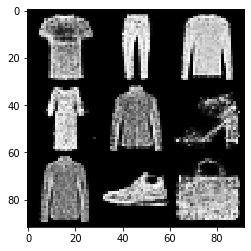

Starting epoch 172...
g_loss: 0.7804397344589233, d_loss: 1.2944296598434448


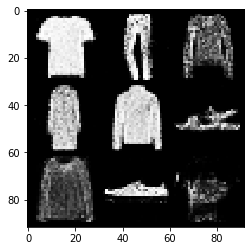

Starting epoch 173...
g_loss: 0.8407691717147827, d_loss: 1.4017233848571777


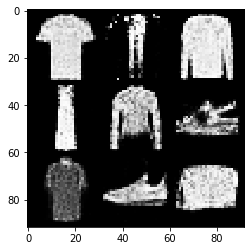

Starting epoch 174...
g_loss: 0.7124946117401123, d_loss: 1.2609361410140991


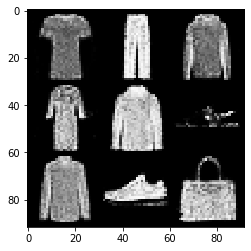

Starting epoch 175...
g_loss: 0.6233265399932861, d_loss: 1.2615700960159302


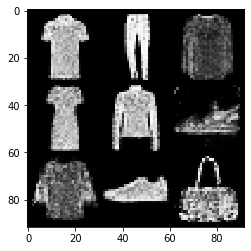

Starting epoch 176...
g_loss: 0.7052933573722839, d_loss: 1.3003456592559814


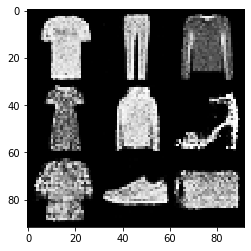

Starting epoch 177...
g_loss: 0.6311955451965332, d_loss: 1.263524055480957


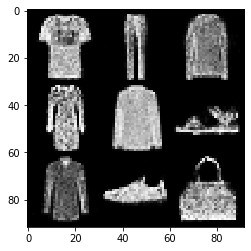

Starting epoch 178...
g_loss: 0.6905317306518555, d_loss: 1.2897517681121826


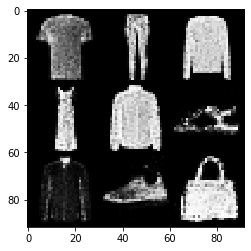

Starting epoch 179...
g_loss: 0.7496942281723022, d_loss: 1.2079346179962158


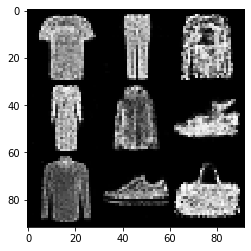

Starting epoch 180...
g_loss: 0.8060197830200195, d_loss: 1.3467628955841064


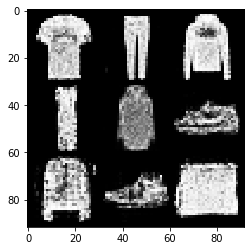

Starting epoch 181...
g_loss: 0.7509627938270569, d_loss: 1.2483025789260864


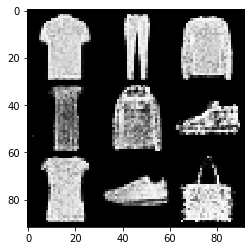

Starting epoch 182...
g_loss: 0.680594801902771, d_loss: 1.267380952835083


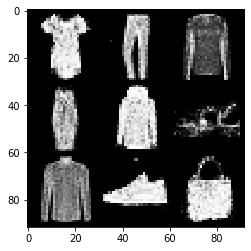

Starting epoch 183...
g_loss: 0.9404041767120361, d_loss: 1.2466070652008057


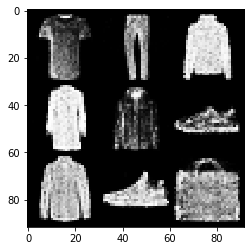

Starting epoch 184...
g_loss: 0.8155195713043213, d_loss: 1.3264895677566528


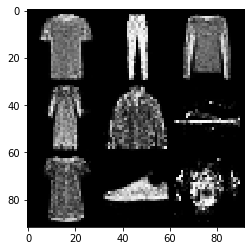

Starting epoch 185...
g_loss: 0.8449673652648926, d_loss: 1.2350208759307861


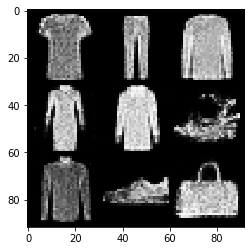

Starting epoch 186...
g_loss: 0.7022048830986023, d_loss: 1.275517225265503


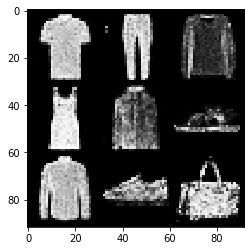

Starting epoch 187...
g_loss: 0.7340850830078125, d_loss: 1.277498722076416


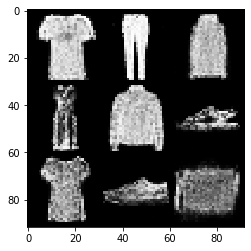

Starting epoch 188...
g_loss: 0.768365740776062, d_loss: 1.256593942642212


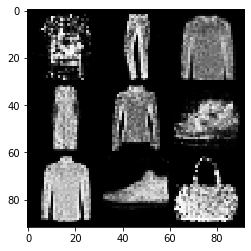

Starting epoch 189...
g_loss: 0.6972476243972778, d_loss: 1.210685133934021


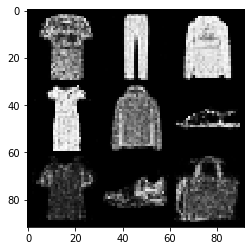

Starting epoch 190...
g_loss: 0.811586856842041, d_loss: 1.296894907951355


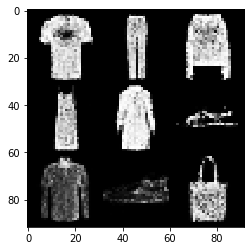

Starting epoch 191...
g_loss: 0.7009450793266296, d_loss: 1.200793743133545


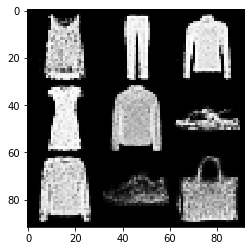

Starting epoch 192...
g_loss: 0.9163469076156616, d_loss: 1.346946120262146


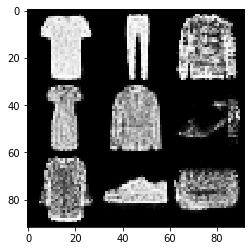

Starting epoch 193...
g_loss: 0.7451155185699463, d_loss: 1.2579617500305176


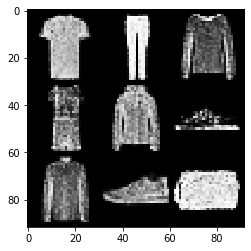

Starting epoch 194...
g_loss: 0.7026503086090088, d_loss: 1.3329529762268066


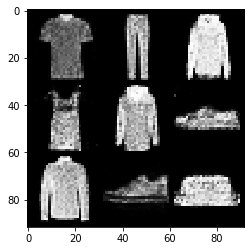

Starting epoch 195...
g_loss: 0.7724295854568481, d_loss: 1.2009634971618652


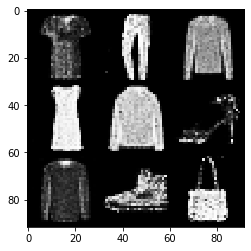

Starting epoch 196...
g_loss: 0.7778026461601257, d_loss: 1.2171111106872559


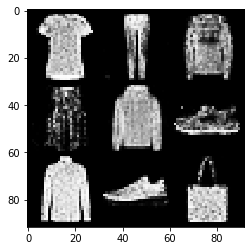

Starting epoch 197...
g_loss: 0.6654661893844604, d_loss: 1.2642695903778076


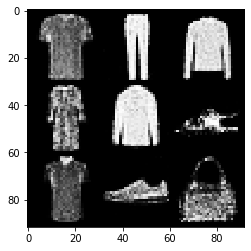

Starting epoch 198...
g_loss: 0.8900871872901917, d_loss: 1.210988998413086


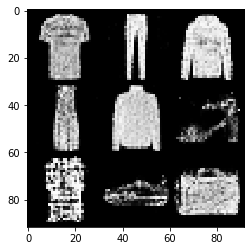

Starting epoch 199...
g_loss: 0.838566780090332, d_loss: 1.2701616287231445


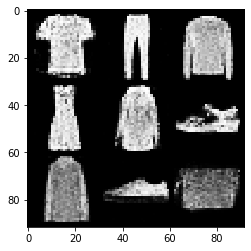

Starting epoch 200...
g_loss: 0.7433248162269592, d_loss: 1.198224663734436


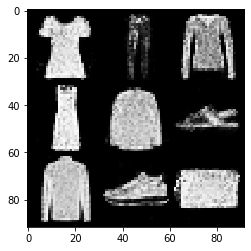

Starting epoch 201...
g_loss: 0.7231400609016418, d_loss: 1.284125804901123


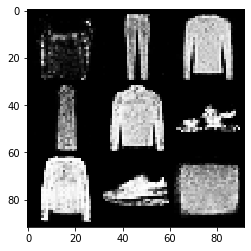

Starting epoch 202...
g_loss: 0.7380164265632629, d_loss: 1.2481515407562256


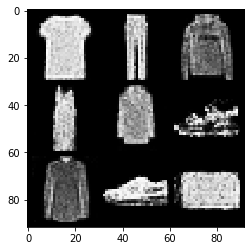

Starting epoch 203...
g_loss: 0.7104400396347046, d_loss: 1.328046202659607


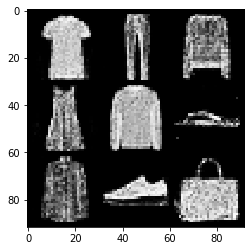

Starting epoch 204...
g_loss: 0.6923518180847168, d_loss: 1.3379905223846436


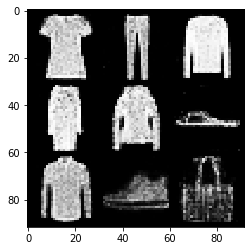

Starting epoch 205...
g_loss: 0.7249268293380737, d_loss: 1.2577626705169678


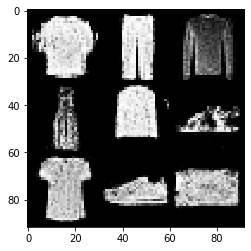

Starting epoch 206...
g_loss: 0.8184300661087036, d_loss: 1.2136118412017822


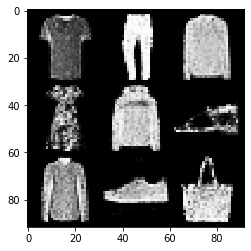

Starting epoch 207...
g_loss: 0.8229862451553345, d_loss: 1.2660714387893677


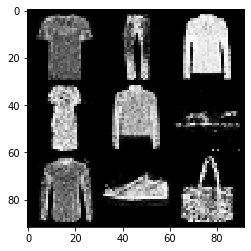

Starting epoch 208...
g_loss: 0.797345757484436, d_loss: 1.2981350421905518


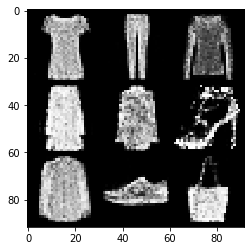

Starting epoch 209...
g_loss: 0.9016205072402954, d_loss: 1.2944880723953247


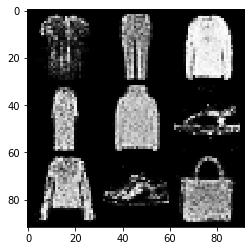

Starting epoch 210...
g_loss: 0.6741644144058228, d_loss: 1.2031360864639282


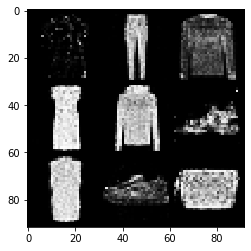

Starting epoch 211...
g_loss: 0.7941408157348633, d_loss: 1.2648570537567139


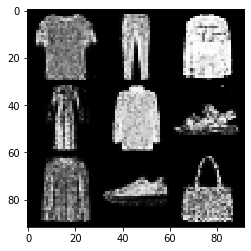

Starting epoch 212...
g_loss: 0.864081621170044, d_loss: 1.2827718257904053


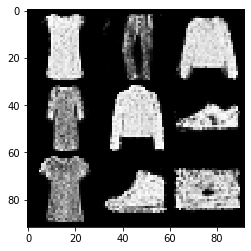

Starting epoch 213...
g_loss: 0.7371091842651367, d_loss: 1.3166611194610596


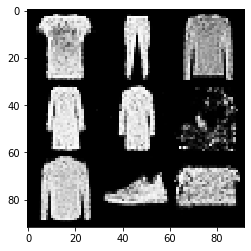

Starting epoch 214...
g_loss: 0.6224606037139893, d_loss: 1.271340012550354


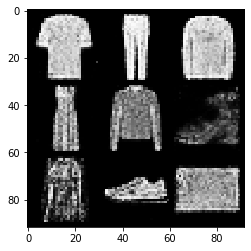

Starting epoch 215...
g_loss: 0.6718372106552124, d_loss: 1.2427359819412231


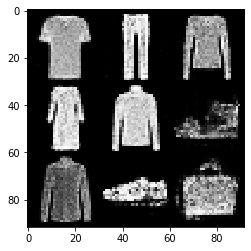

Starting epoch 216...
g_loss: 0.8911834359169006, d_loss: 1.2810394763946533


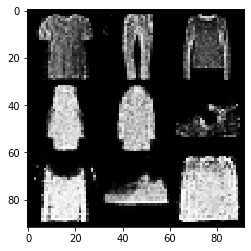

Starting epoch 217...
g_loss: 0.7410286664962769, d_loss: 1.2870875597000122


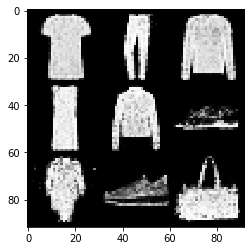

Starting epoch 218...
g_loss: 0.7805583477020264, d_loss: 1.1684989929199219


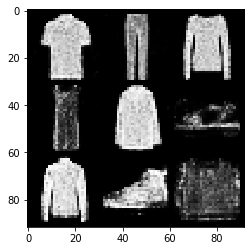

Starting epoch 219...
g_loss: 0.7813432216644287, d_loss: 1.2543171644210815


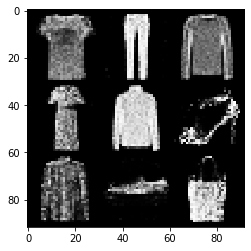

Starting epoch 220...
g_loss: 0.7530021071434021, d_loss: 1.2460436820983887


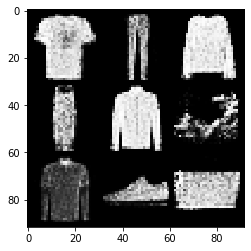

Starting epoch 221...
g_loss: 0.7412583231925964, d_loss: 1.230423092842102


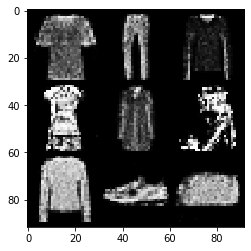

Starting epoch 222...
g_loss: 0.9066181182861328, d_loss: 1.2412989139556885


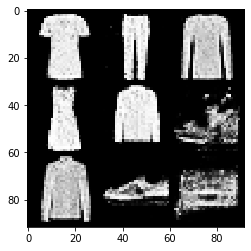

Starting epoch 223...
g_loss: 0.6508464813232422, d_loss: 1.3056578636169434


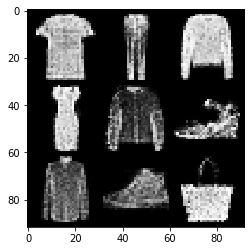

Starting epoch 224...
g_loss: 0.8115934729576111, d_loss: 1.2632019519805908


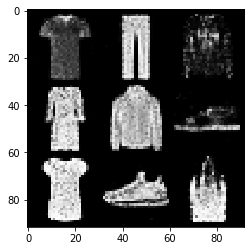

Starting epoch 225...
g_loss: 0.7815786600112915, d_loss: 1.2870286703109741


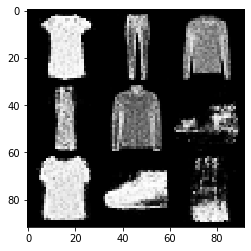

Starting epoch 226...
g_loss: 0.8864916563034058, d_loss: 1.3307647705078125


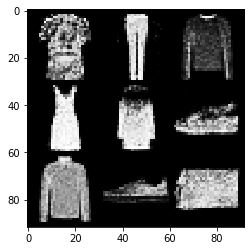

Starting epoch 227...
g_loss: 0.884233832359314, d_loss: 1.2748258113861084


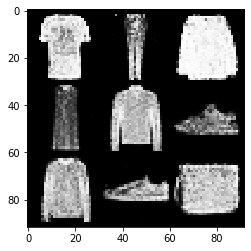

Starting epoch 228...
g_loss: 0.6548604965209961, d_loss: 1.2034028768539429


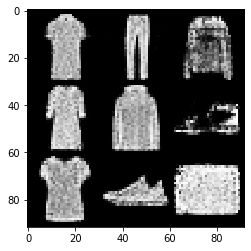

Starting epoch 229...
g_loss: 0.665977954864502, d_loss: 1.1828644275665283


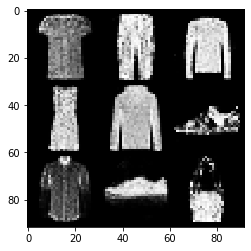

Starting epoch 230...
g_loss: 0.8598342537879944, d_loss: 1.2860498428344727


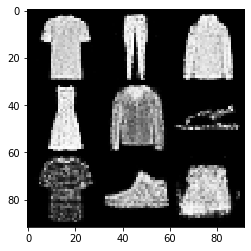

Starting epoch 231...
g_loss: 0.6260544061660767, d_loss: 1.3078672885894775


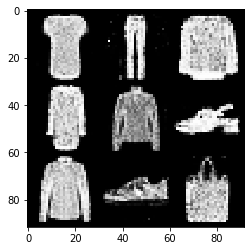

Starting epoch 232...
g_loss: 0.8542848825454712, d_loss: 1.2461258172988892


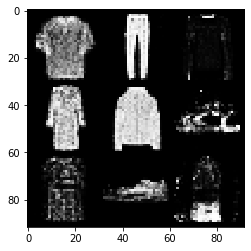

Starting epoch 233...
g_loss: 0.8442854881286621, d_loss: 1.2006080150604248


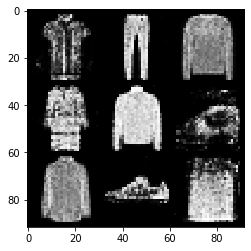

Starting epoch 234...
g_loss: 0.886958122253418, d_loss: 1.2078732252120972


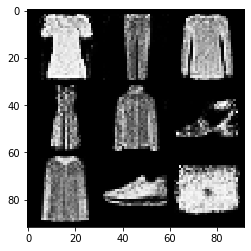

Starting epoch 235...
g_loss: 0.8017845153808594, d_loss: 1.3299291133880615


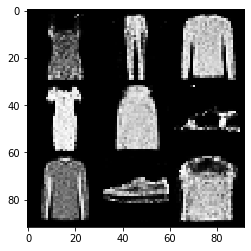

Starting epoch 236...
g_loss: 0.7512478828430176, d_loss: 1.2304258346557617


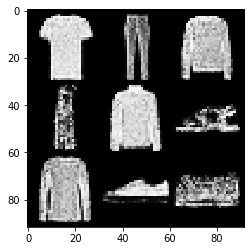

Starting epoch 237...
g_loss: 0.8581658005714417, d_loss: 1.2053039073944092


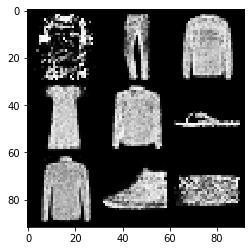

Starting epoch 238...
g_loss: 0.7947869896888733, d_loss: 1.238748550415039


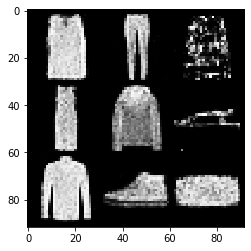

Starting epoch 239...
g_loss: 0.7079803347587585, d_loss: 1.3083841800689697


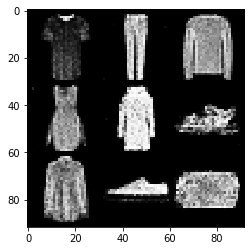

Starting epoch 240...
g_loss: 0.7860488295555115, d_loss: 1.2817680835723877


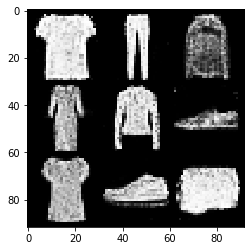

Starting epoch 241...
g_loss: 0.7986878156661987, d_loss: 1.277701735496521


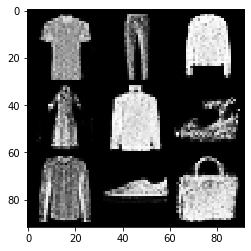

Starting epoch 242...
g_loss: 0.6689926385879517, d_loss: 1.242260456085205


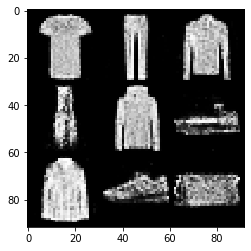

Starting epoch 243...
g_loss: 0.659953773021698, d_loss: 1.1895005702972412


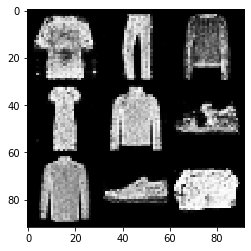

Starting epoch 244...
g_loss: 0.7907211184501648, d_loss: 1.2530114650726318


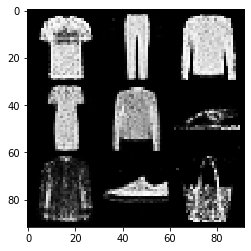

Starting epoch 245...
g_loss: 0.8334877490997314, d_loss: 1.3323869705200195


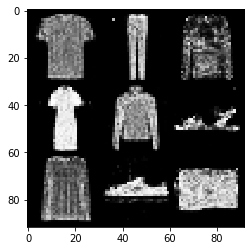

Starting epoch 246...
g_loss: 0.6158248782157898, d_loss: 1.2779009342193604


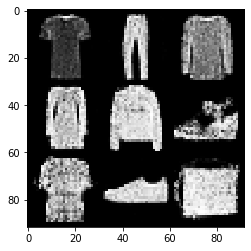

Starting epoch 247...
g_loss: 0.850445568561554, d_loss: 1.2927166223526


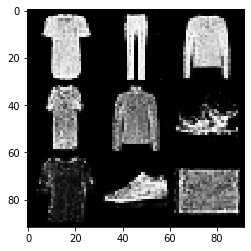

Starting epoch 248...
g_loss: 0.8423323631286621, d_loss: 1.2663259506225586


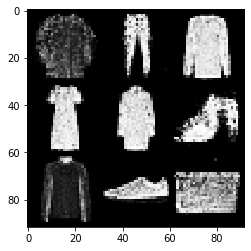

Starting epoch 249...
g_loss: 0.7654861211776733, d_loss: 1.2669321298599243


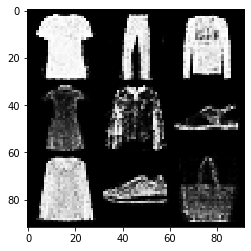

Starting epoch 250...
g_loss: 0.8424494862556458, d_loss: 1.300337553024292


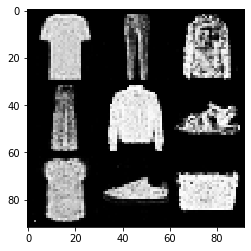

Starting epoch 251...
g_loss: 0.8734021782875061, d_loss: 1.2252472639083862


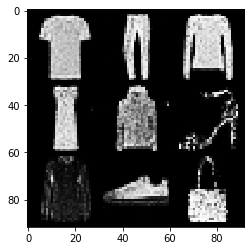

Starting epoch 252...
g_loss: 0.790392279624939, d_loss: 1.2403006553649902


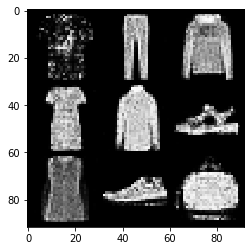

Starting epoch 253...
g_loss: 0.8564351201057434, d_loss: 1.2660131454467773


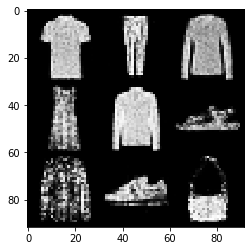

Starting epoch 254...
g_loss: 0.8487815856933594, d_loss: 1.2485084533691406


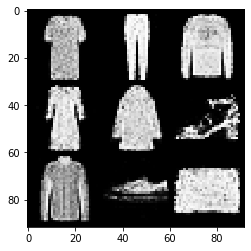

Starting epoch 255...
g_loss: 0.8205317258834839, d_loss: 1.2957336902618408


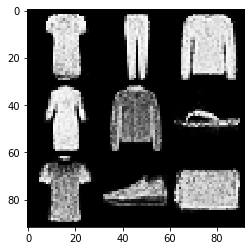

Starting epoch 256...
g_loss: 0.7923709750175476, d_loss: 1.3194241523742676


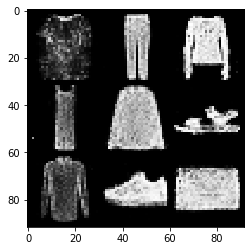

Starting epoch 257...
g_loss: 0.7161692380905151, d_loss: 1.296804428100586


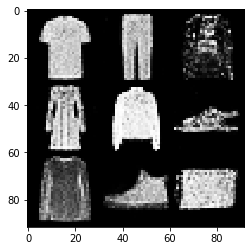

Starting epoch 258...
g_loss: 0.8222256302833557, d_loss: 1.2029982805252075


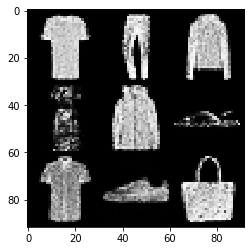

Starting epoch 259...
g_loss: 0.7507117986679077, d_loss: 1.2309376001358032


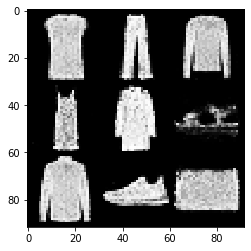

Starting epoch 260...
g_loss: 0.9505540728569031, d_loss: 1.1757380962371826


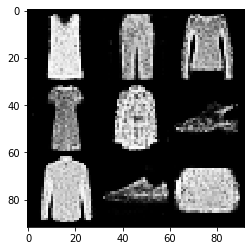

Starting epoch 261...
g_loss: 0.8369016647338867, d_loss: 1.2114932537078857


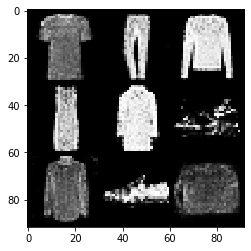

Starting epoch 262...
g_loss: 0.7742891311645508, d_loss: 1.2596373558044434


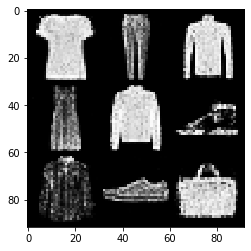

Starting epoch 263...
g_loss: 0.7566736936569214, d_loss: 1.199411153793335


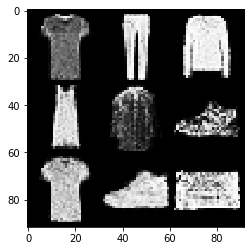

Starting epoch 264...
g_loss: 0.8121130466461182, d_loss: 1.2389111518859863


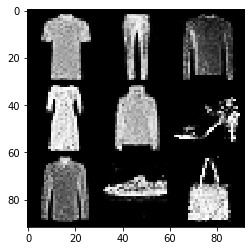

Starting epoch 265...
g_loss: 0.7376996278762817, d_loss: 1.205976963043213


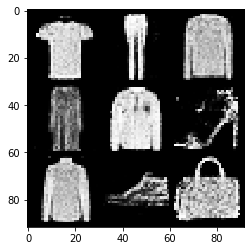

Starting epoch 266...
g_loss: 0.8377823233604431, d_loss: 1.2264705896377563


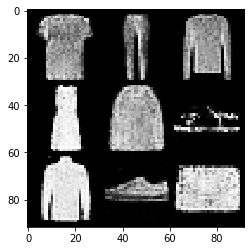

Starting epoch 267...
g_loss: 0.7936819791793823, d_loss: 1.185266375541687


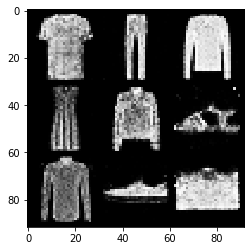

Starting epoch 268...
g_loss: 0.9045147895812988, d_loss: 1.2773749828338623


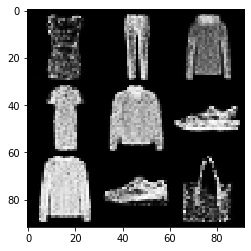

Starting epoch 269...
g_loss: 0.8653111457824707, d_loss: 1.2467377185821533


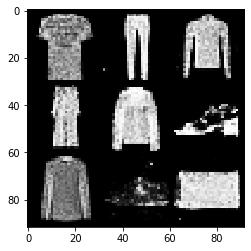

Starting epoch 270...
g_loss: 0.6514235734939575, d_loss: 1.2721903324127197


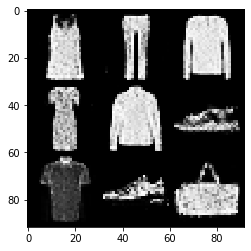

Starting epoch 271...
g_loss: 0.746506929397583, d_loss: 1.2332525253295898


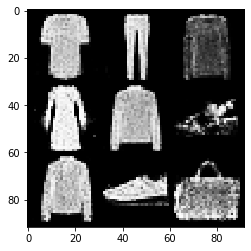

Starting epoch 272...
g_loss: 0.7104754447937012, d_loss: 1.20188570022583


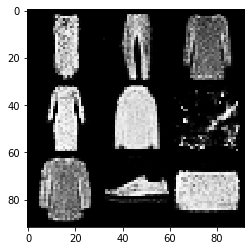

Starting epoch 273...
g_loss: 0.9495142698287964, d_loss: 1.2544763088226318


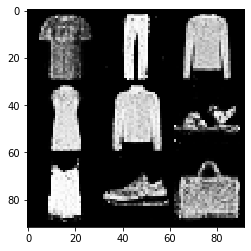

Starting epoch 274...
g_loss: 0.8930872678756714, d_loss: 1.2676432132720947


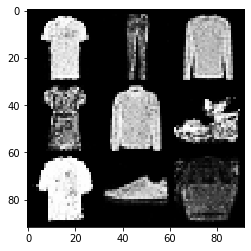

Starting epoch 275...
g_loss: 0.7795108556747437, d_loss: 1.2392404079437256


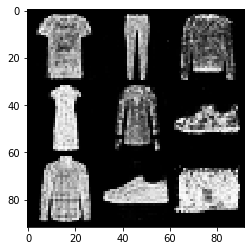

Starting epoch 276...
g_loss: 0.8108621835708618, d_loss: 1.2411582469940186


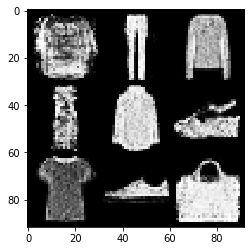

Starting epoch 277...
g_loss: 1.044095516204834, d_loss: 1.310652494430542


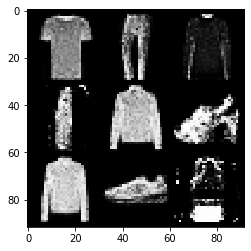

Starting epoch 278...
g_loss: 0.8388566970825195, d_loss: 1.197298288345337


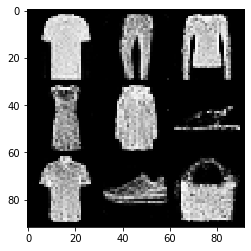

Starting epoch 279...
g_loss: 0.8315640687942505, d_loss: 1.2342569828033447


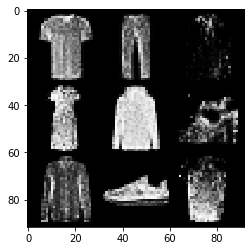

Starting epoch 280...
g_loss: 0.875603437423706, d_loss: 1.320023775100708


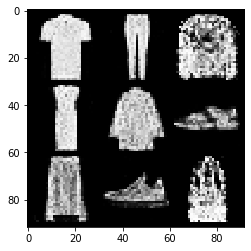

Starting epoch 281...
g_loss: 0.8950986266136169, d_loss: 1.1723504066467285


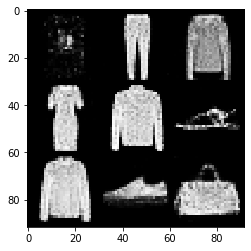

Starting epoch 282...
g_loss: 0.953472375869751, d_loss: 1.2063138484954834


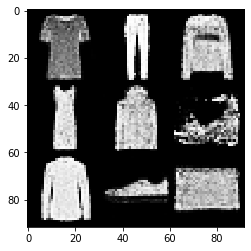

Starting epoch 283...
g_loss: 0.7218900322914124, d_loss: 1.2980616092681885


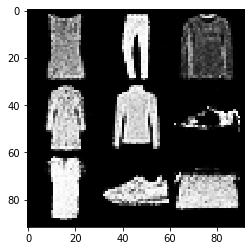

Starting epoch 284...
g_loss: 0.6675413846969604, d_loss: 1.3418209552764893


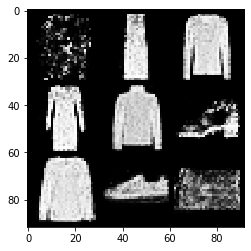

Starting epoch 285...
g_loss: 0.7551800012588501, d_loss: 1.241642713546753


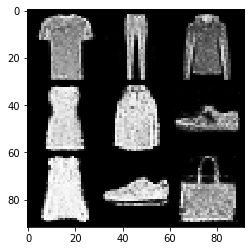

Starting epoch 286...
g_loss: 0.8839795589447021, d_loss: 1.294280767440796


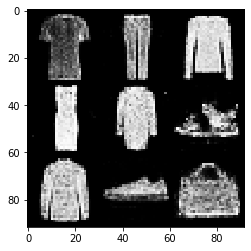

Starting epoch 287...
g_loss: 0.978665292263031, d_loss: 1.2963544130325317


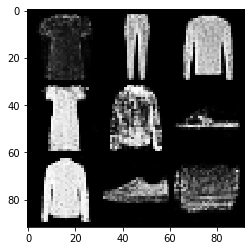

Starting epoch 288...
g_loss: 0.8144380450248718, d_loss: 1.3423874378204346


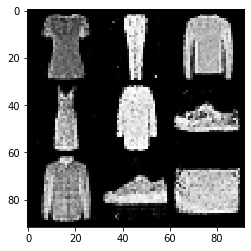

Starting epoch 289...
g_loss: 0.8733986616134644, d_loss: 1.2484272718429565


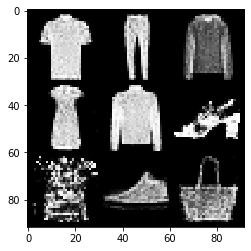

Starting epoch 290...
g_loss: 0.7735666036605835, d_loss: 1.2874597311019897


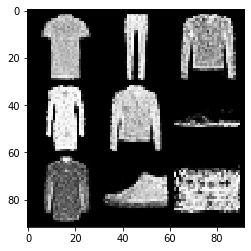

Starting epoch 291...
g_loss: 0.7967672944068909, d_loss: 1.244197130203247


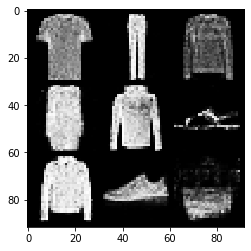

Starting epoch 292...
g_loss: 0.8379859328269958, d_loss: 1.1750426292419434


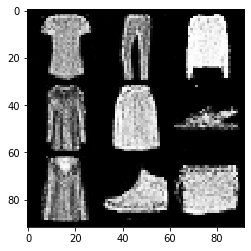

Starting epoch 293...
g_loss: 0.7929986715316772, d_loss: 1.2437033653259277


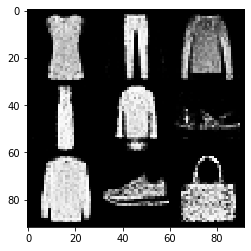

Starting epoch 294...
g_loss: 0.7820687294006348, d_loss: 1.2590415477752686


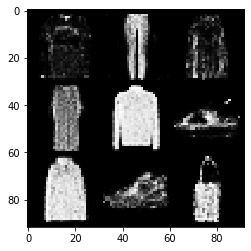

Starting epoch 295...
g_loss: 0.9075847864151001, d_loss: 1.251285433769226


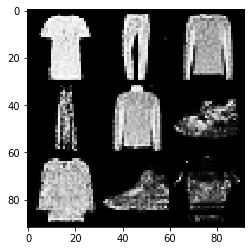

Starting epoch 296...
g_loss: 0.8226866722106934, d_loss: 1.2095303535461426


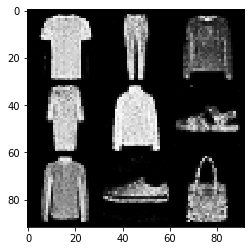

Starting epoch 297...
g_loss: 0.9503191709518433, d_loss: 1.2567744255065918


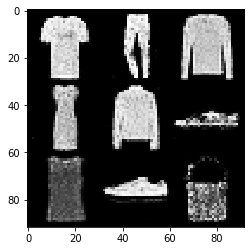

Starting epoch 298...
g_loss: 1.0420737266540527, d_loss: 1.2689988613128662


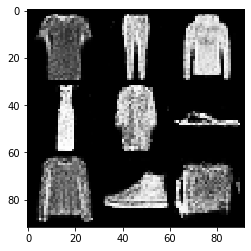

Starting epoch 299...
g_loss: 0.8704224824905396, d_loss: 1.2144103050231934


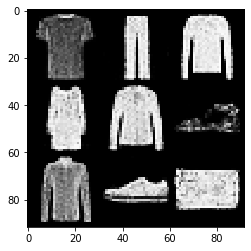

5492.64525437355


In [10]:
num_epochs = 300
start_time = time.time()
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch))
    for i, (images, labels) in enumerate(data_loader):
        real_images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

    generator.eval()
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    z = Variable(torch.LongTensor(np.random.normal(0, 1, (9, 100)))).cuda()
    labels = Variable(torch.LongTensor(np.arange(9))).cuda()
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()
elapsed_time = time.time() - start_time
print(elapsed_time)